CRAIG CHOSNEY <br>
CSC 74020 FINAL PROJECT

In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

## SCRAPE FINANCIAL DATA AND CREATE DATASET

In [ ]:
# Define tickers manually
tickers = ['VZ', 'XOM', 'JPM', 'LH', 'PG']

# Define time range
start = dt.datetime(1991, 5, 1)
end = dt.datetime.now()

# Create directory if it doesn't exist
if not os.path.exists('stock_dfs'):
    os.makedirs('stock_dfs')

# Fetch stock data using yfinance
for ticker in tickers:
    filepath = f'stock_dfs/{ticker}.csv'
    if not os.path.exists(filepath):
        try:
            data = yf.download(ticker, start=start, end=end)
            data.to_csv(filepath)
        except Exception as e:
            print(f"Failed to fetch data for {ticker}: {e}")
    else:
        print(f'Already have {ticker}')


Already have VZ
Already have XOM
Already have JPM
Already have LH
Already have PG


In [ ]:
# Define the directory containing CSV files
directory = 'stock_dfs'

# Initialize a list to store each DataFrame
dfs = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Check if the file is a CSV
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)

        # Optionally add a column to identify the stock ticker from the filename
        df['Ticker'] = filename.split('.')[0]

        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Save the combined DataFrame to a new CSV file or process it
combined_df.to_csv('combined_stocks.csv', index=False)
print('Aggregated stock data saved to combined_stocks.csv.')


Aggregated stock data saved to combined_stocks.csv.


In [ ]:
# Load the combined CSV file
df = pd.read_csv('combined_stocks.csv', parse_dates=['Date'])  # Ensure 'Date' is your date column name

# Filter for the first day of each month
df['MonthYear'] = df['Date'].dt.to_period('M')  # Create a period column for easier filtering
first_of_month_df = df.groupby('MonthYear').apply(lambda x: x[x['Date'] == x['Date'].min()])

# Drop the extra index level added by groupby
first_of_month_df.reset_index(drop=True, inplace=True)

# Save the filtered data or process it
first_of_month_df.to_csv('first_of_month_stocks.csv', index=False)
print('Filtered stock data for the first of each month saved to first_of_month_stocks.csv.')


Filtered stock data for the first of each month saved to first_of_month_stocks.csv.


## EXPLORATORY DATA ANALYSIS

In [ ]:
# Load the data
file_path = '/content/combined_stocks.csv'
data = pd.read_csv(file_path)

# Display basic information and the first few rows of the dataset
data_info = data.info()
first_rows = data.head()

data_info, first_rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41625 entries, 0 to 41624
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       41625 non-null  object 
 1   Open       41625 non-null  float64
 2   High       41625 non-null  float64
 3   Low        41625 non-null  float64
 4   Close      41625 non-null  float64
 5   Adj Close  41625 non-null  float64
 6   Volume     41625 non-null  int64  
 7   Ticker     41625 non-null  object 
dtypes: float64(5), int64(1), object(2)
memory usage: 2.5+ MB


(None,
          Date       Open       High        Low      Close  Adj Close   Volume  \
 0  1991-05-01  37.854382  38.659794  37.854382  38.659794  35.824989  2813854   
 1  1991-05-02  38.391323  38.659794  37.854382  38.659794  35.824989   888085   
 2  1991-05-03  38.391323  38.659794  38.391323  38.659794  35.824989   421415   
 3  1991-05-06  38.391323  43.223797  38.391323  42.686855  39.556763   987677   
 4  1991-05-07  42.149914  42.418385  40.270618  41.881443  38.810402   566402   
 
   Ticker  
 0     LH  
 1     LH  
 2     LH  
 3     LH  
 4     LH  )

In [ ]:
# Convert 'Date' and 'MonthYear' columns to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Verify the conversion
conversion_check = data.dtypes

# Generate summary statistics for numerical columns
summary_statistics = data.describe()

conversion_check, summary_statistics


(Date         datetime64[ns]
 Open                float64
 High                float64
 Low                 float64
 Close               float64
 Adj Close           float64
 Volume                int64
 Ticker               object
 dtype: object,
                                 Date          Open          High  \
 count                          41625  41625.000000  41625.000000   
 mean   2007-11-03 20:27:24.972973056     59.105839     59.675995   
 min              1991-05-01 00:00:00      2.684708      2.818943   
 25%              1999-07-27 00:00:00     32.343750     32.731960   
 50%              2007-11-02 00:00:00     47.750000     48.250000   
 75%              2016-02-10 00:00:00     77.010002     77.669998   
 max              2024-05-17 00:00:00    269.106537    272.482819   
 std                              NaN     41.795411     42.152617   
 
                 Low         Close     Adj Close        Volume  
 count  41625.000000  41625.000000  41625.000000  4.162500e+04  

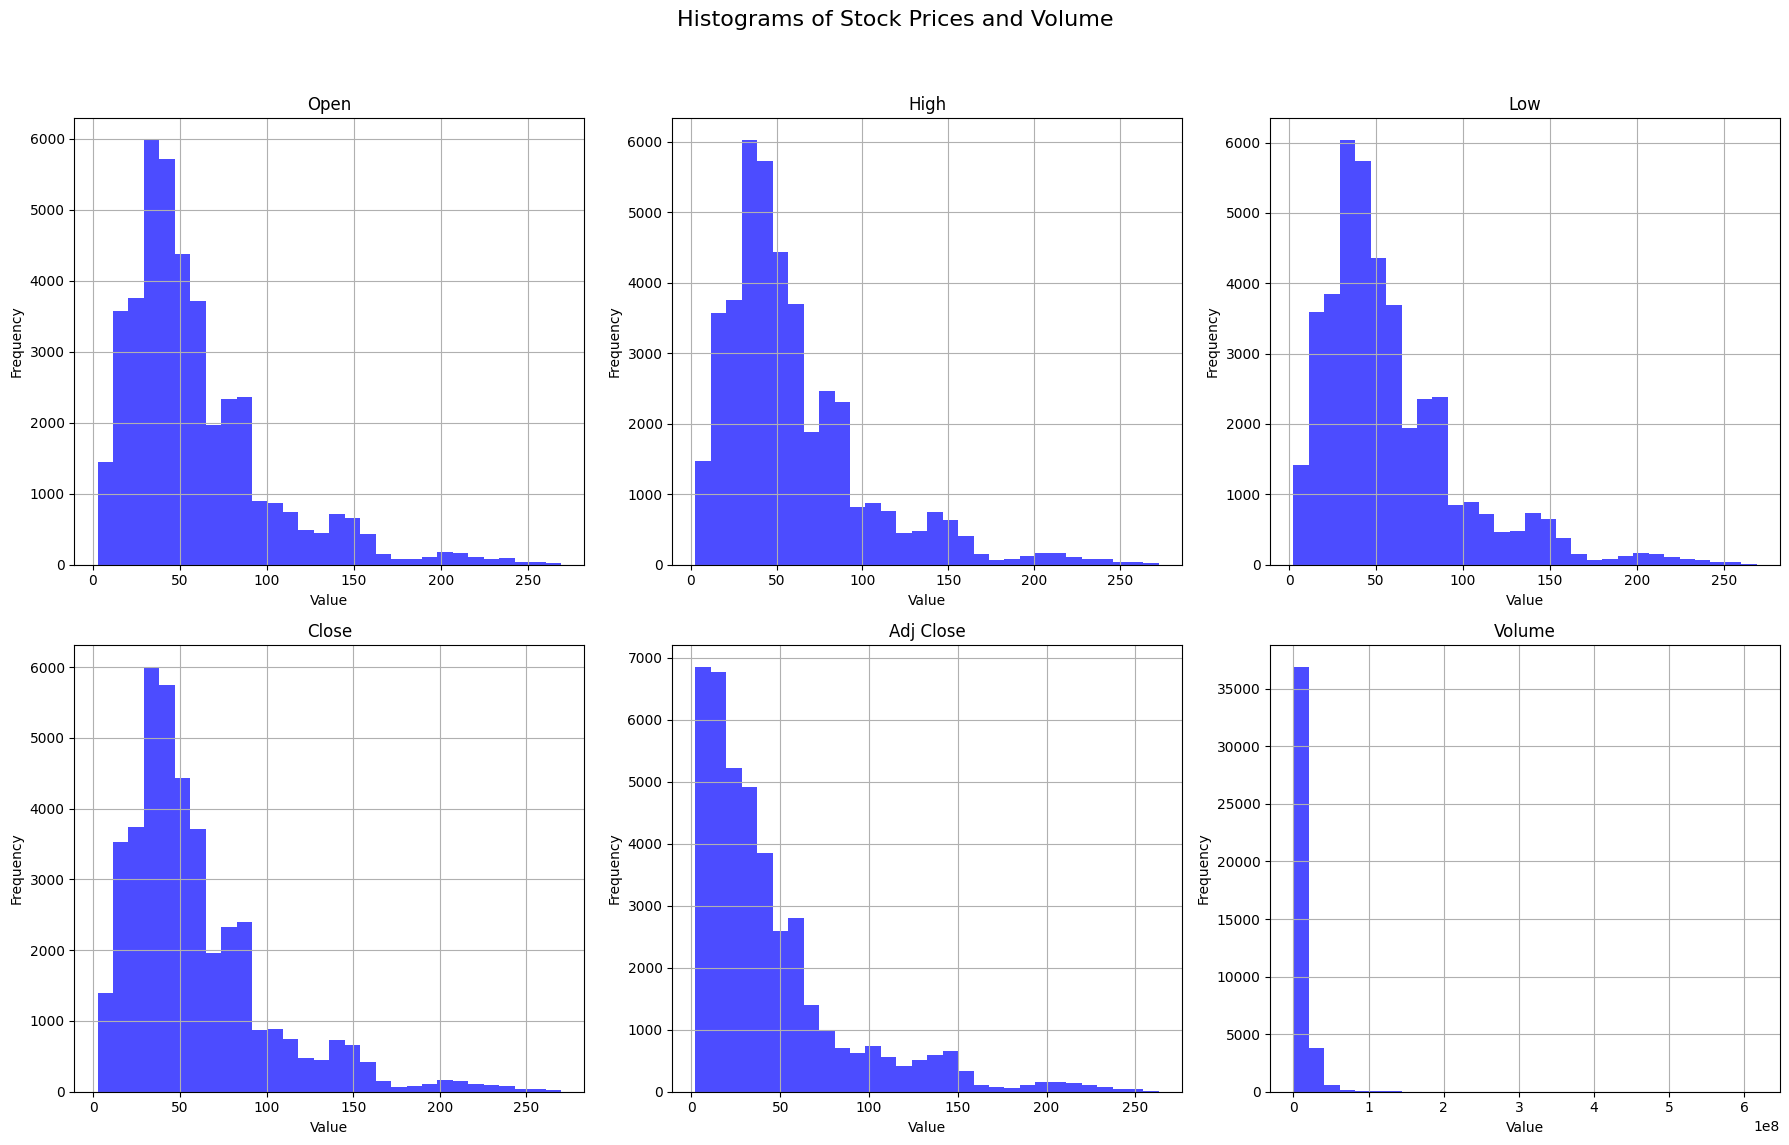

In [ ]:
# Set up the figure and axes for the histograms
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Histograms of Stock Prices and Volume', fontsize=16)

# List of columns to plot
columns_to_plot = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Plot histograms
for ax, column in zip(axes.flatten(), columns_to_plot):
    data[column].hist(ax=ax, bins=30, alpha=0.7, color='blue')
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


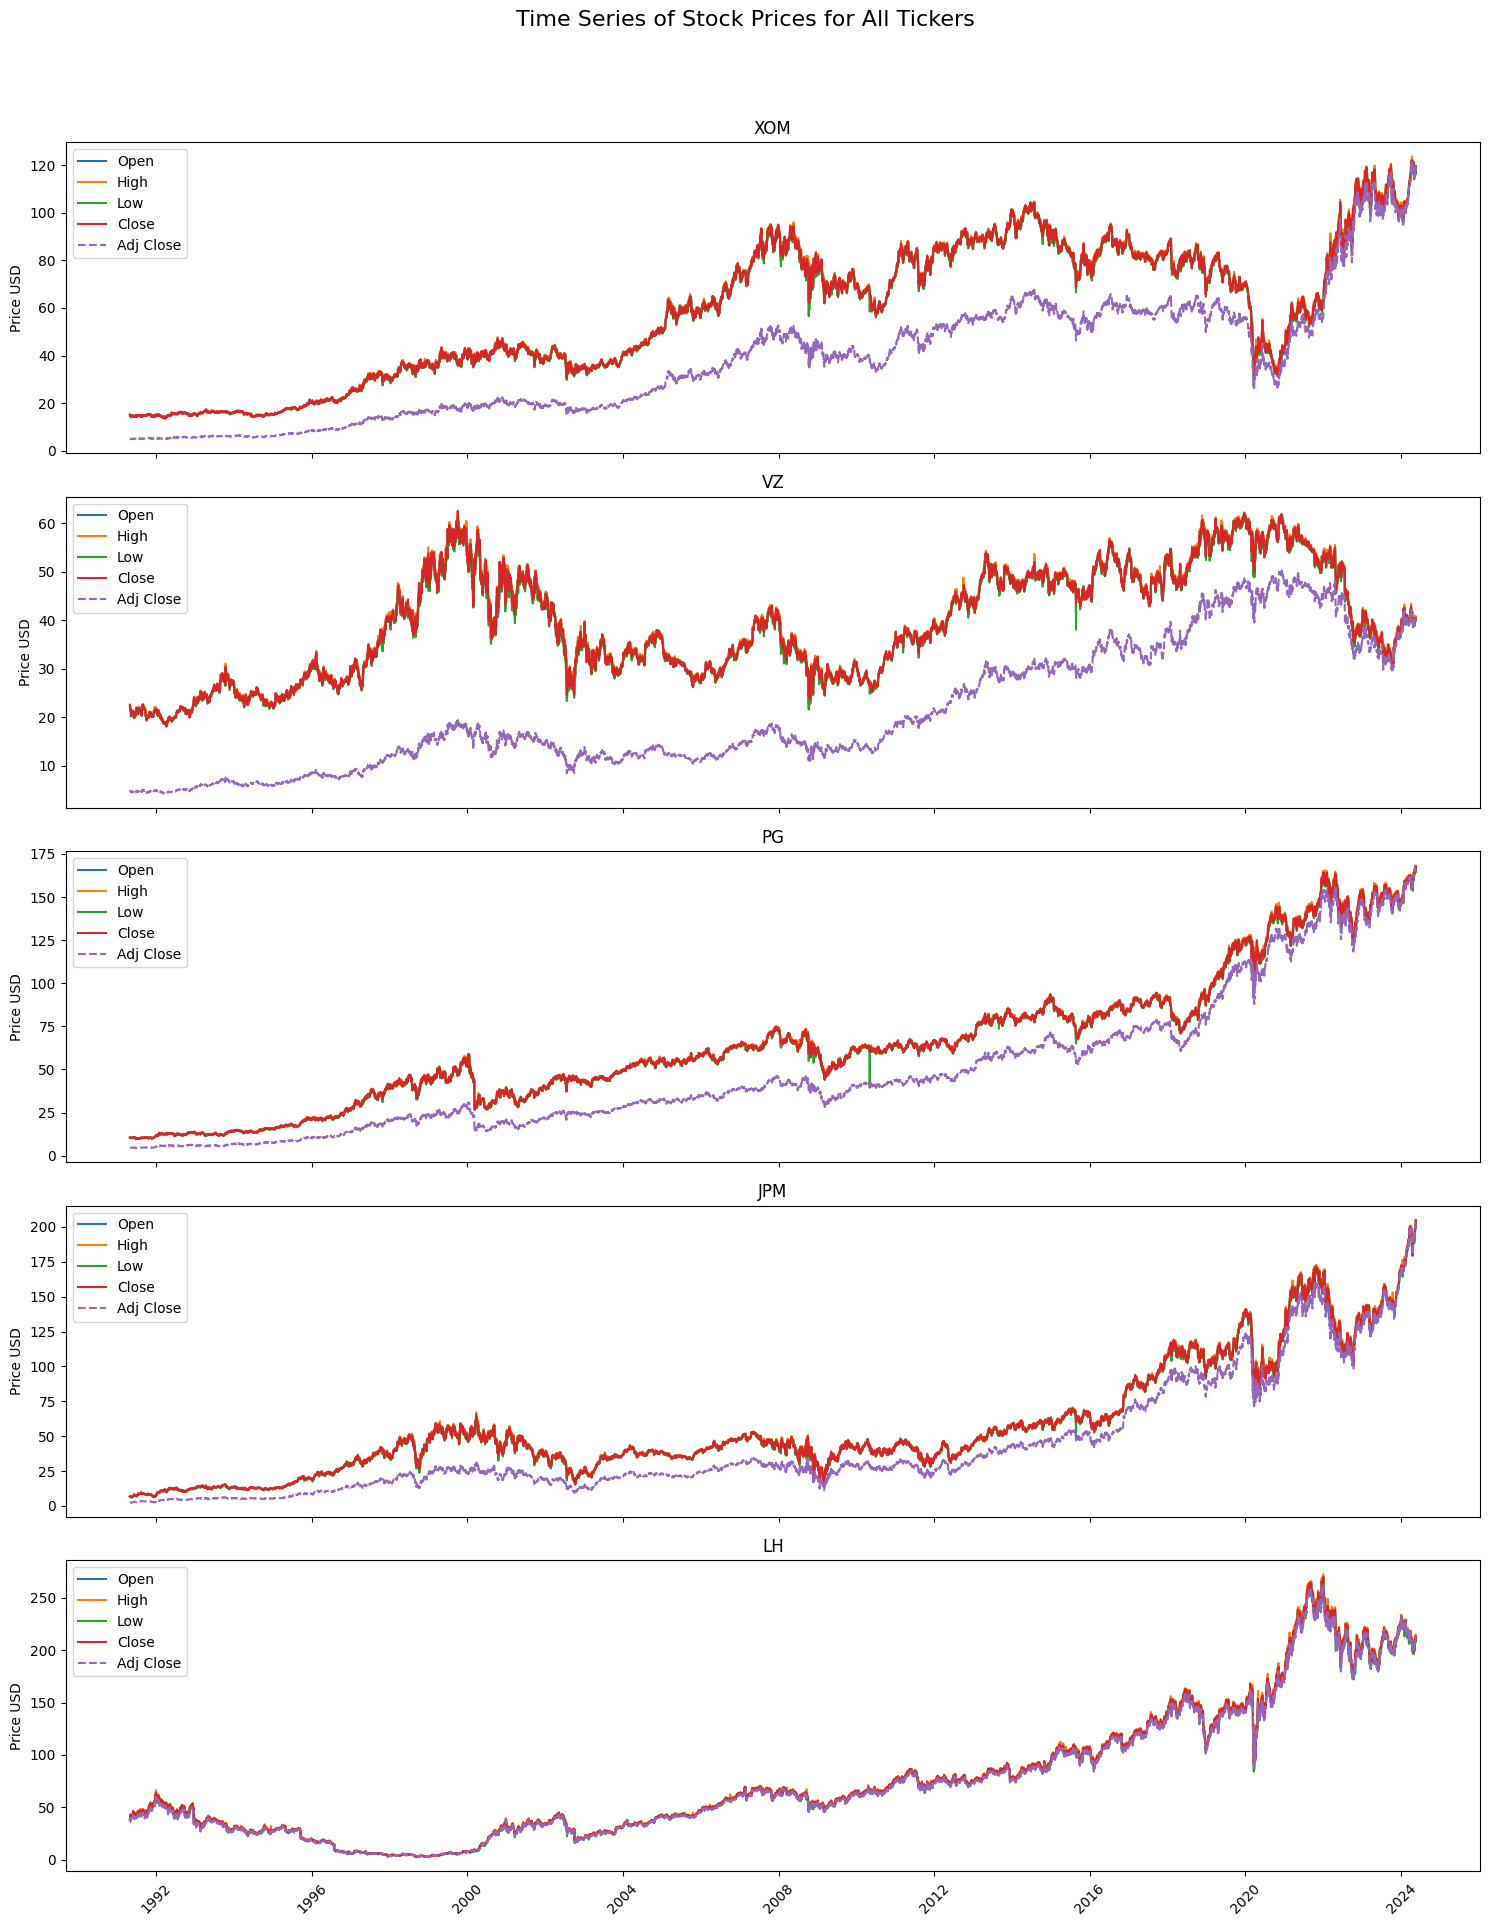

In [ ]:
# Set up the figure and axes for the time series plots for all tickers
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 20), sharex=True)
fig.suptitle('Time Series of Stock Prices for All Tickers', fontsize=16)

# List of tickers
tickers = ['XOM', 'VZ', 'PG', 'JPM', 'LH']

# Plot each ticker
for ax, ticker in zip(axes, tickers):
    ticker_data = data[data['Ticker'] == ticker]
    ax.plot(ticker_data['Date'], ticker_data['Open'], label='Open')
    ax.plot(ticker_data['Date'], ticker_data['High'], label='High')
    ax.plot(ticker_data['Date'], ticker_data['Low'], label='Low')
    ax.plot(ticker_data['Date'], ticker_data['Close'], label='Close')
    ax.plot(ticker_data['Date'], ticker_data['Adj Close'], label='Adj Close', linestyle='--')
    ax.set_title(ticker)
    ax.legend(loc='upper left')
    ax.set_ylabel('Price USD')

# Adjust layout and axis
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.xticks(rotation=45)
plt.show()


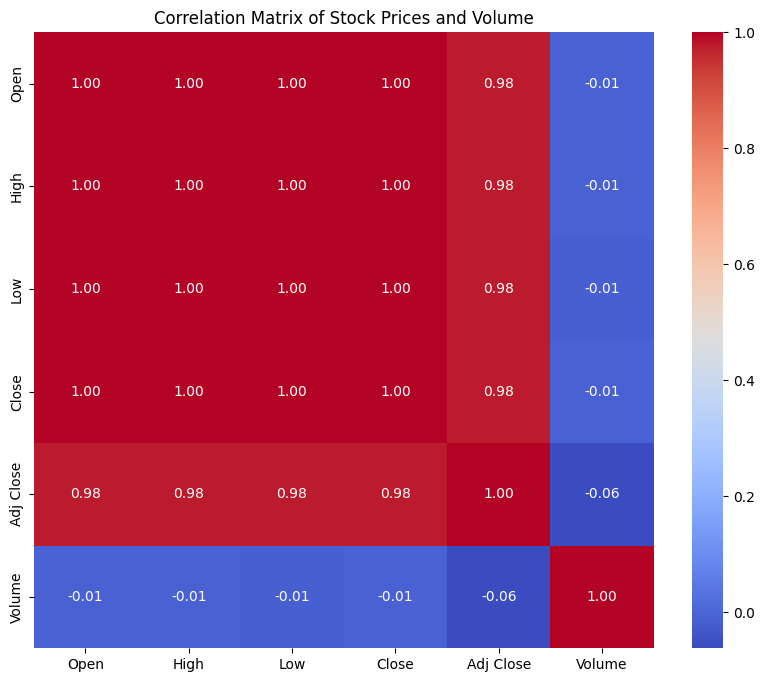

In [ ]:
# Calculate the correlation matrix
correlation_matrix = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Stock Prices and Volume')
plt.show()


## FEATURE ENGINEERING

In [ ]:
# Engineer Lag Features

features_to_lag = ['Close', 'Open', 'High', 'Low', 'Adj Close', 'Volume']
number_of_lags = 7

for feature in features_to_lag:
    for lag in range(1, number_of_lags + 1):
        data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)

data = data.dropna()  # Drop rows with NaN values


In [ ]:
# Rolling Window Functions

# Creating a 7-day rolling average for the close price
data['Close_7day_MA'] = data['Close'].rolling(window=7).mean()

# Creating a 7-day rolling standard deviation for the close price
data['Close_7day_std'] = data['Close'].rolling(window=7).std()

data = data.dropna()  # Again, remove rows with NaN values that result from rolling calculations


In [ ]:
# Exponential moving averages (EMAs)

# Add Exponential Moving Average for 7 days
data['Close_7day_EMA'] = data['Close'].ewm(span=7, adjust=False).mean()


## CREATE TARGET VARIABLE/ PREPROCESS FOR MODELLING:

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Close_lag_1,Close_lag_2,...,Volume_lag_1,Volume_lag_2,Volume_lag_3,Volume_lag_4,Volume_lag_5,Volume_lag_6,Volume_lag_7,Close_7day_MA,Close_7day_std,Close_7day_EMA
13,1991-05-20,40.807560,41.076031,40.270618,40.807560,37.815258,64625,LH,40.539089,40.807560,...,70492.0,178837.0,145034.0,127807.0,109230.0,106995.0,221439.0,40.807560,0.346594,40.807560
14,1991-05-21,40.539089,41.881443,40.539089,41.612972,38.561623,101640,LH,40.807560,40.539089,...,64625.0,70492.0,178837.0,145034.0,127807.0,109230.0,106995.0,40.884266,0.457564,41.008913
15,1991-05-22,41.881443,43.223797,41.612972,42.955326,39.805531,148107,LH,41.612972,40.807560,...,101640.0,64625.0,70492.0,178837.0,145034.0,127807.0,109230.0,41.267796,0.830587,41.495516
16,1991-05-23,43.492268,43.760738,42.686855,42.955326,39.805531,309252,LH,42.955326,41.612972,...,148107.0,101640.0,64625.0,70492.0,178837.0,145034.0,127807.0,41.497913,1.049639,41.860469
17,1991-05-24,42.955326,42.955326,42.686855,42.955326,39.805531,125107,LH,42.955326,42.955326,...,309252.0,148107.0,101640.0,64625.0,70492.0,178837.0,145034.0,41.804737,1.125383,42.134183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41620,2024-05-13,118.419998,119.040001,117.120003,117.910004,116.960007,15060600,XOM,117.959999,118.440002,...,13648100.0,17564000.0,18957200.0,30122000.0,31401300.0,28023300.0,25513600.0,117.054286,1.022789,117.529795
41621,2024-05-14,116.790001,117.739998,116.480003,117.669998,117.669998,15079100,XOM,117.910004,117.959999,...,15060600.0,13648100.0,17564000.0,18957200.0,30122000.0,31401300.0,28023300.0,117.292858,0.926081,117.564846
41622,2024-05-15,117.610001,118.839996,116.080002,118.580002,118.580002,18244300,XOM,117.669998,117.910004,...,15079100.0,15060600.0,13648100.0,17564000.0,18957200.0,30122000.0,31401300.0,117.554286,1.002445,117.818635
41623,2024-05-16,118.540001,119.300003,117.540001,117.870003,117.870003,15745200,XOM,118.580002,117.669998,...,18244300.0,15079100.0,15060600.0,13648100.0,17564000.0,18957200.0,30122000.0,117.797144,0.795817,117.831477


In [ ]:
# Ensure 'data' is a standalone DataFrame
data = data.copy()

# Use .loc to create the 'Next_Day_Close' column to avoid SettingWithCopyWarning
data.loc[:, 'Next_Day_Close'] = data['Close'].shift(-1)

# Use .loc to create the 'Market_Trend' column safely
data.loc[:, 'Market_Trend'] = (data['Next_Day_Close'] > data['Close']).astype(int)

# Drop the last row since it will have NaN for 'Next_Day_Close'
data.dropna(subset=['Next_Day_Close'], inplace=True)

# Display the first few rows to confirm the encoding
data[['Date', 'Ticker', 'Open', 'Close', 'Next_Day_Close', 'Market_Trend']].head()


,Date,Ticker,Open,Close,Next_Day_Close,Market_Trend
13,1991-05-20,LH,40.807560,40.807560,41.612972,1
14,1991-05-21,LH,40.539089,41.612972,42.955326,1
15,1991-05-22,LH,41.881443,42.955326,42.955326,0
16,1991-05-23,LH,43.492268,42.955326,42.955326,0
17,1991-05-24,LH,42.955326,42.955326,43.760738,1


In [ ]:
#REMOVE HIGHLY CORRELATED FEATURES

# Remove the highly correlated features from the dataset
data_reduced = data.drop(['Close'], axis=1)

# Check the first few rows of the updated dataset to ensure it's correct
data_reduced.head()



,Date,Open,High,Low,Adj Close,Volume,Ticker,Close_lag_1,Close_lag_2,Close_lag_3,...,Volume_lag_3,Volume_lag_4,Volume_lag_5,Volume_lag_6,Volume_lag_7,Close_7day_MA,Close_7day_std,Close_7day_EMA,Next_Day_Close,Market_Trend
13,1991-05-20,40.807560,41.076031,40.270618,37.815258,64625,LH,40.539089,40.807560,40.807560,...,145034.0,127807.0,109230.0,106995.0,221439.0,40.807560,0.346594,40.807560,41.612972,1
14,1991-05-21,40.539089,41.881443,40.539089,38.561623,101640,LH,40.807560,40.539089,40.807560,...,178837.0,145034.0,127807.0,109230.0,106995.0,40.884266,0.457564,41.008913,42.955326,1
15,1991-05-22,41.881443,43.223797,41.612972,39.805531,148107,LH,41.612972,40.807560,40.539089,...,70492.0,178837.0,145034.0,127807.0,109230.0,41.267796,0.830587,41.495516,42.955326,0
16,1991-05-23,43.492268,43.760738,42.686855,39.805531,309252,LH,42.955326,41.612972,40.807560,...,64625.0,70492.0,178837.0,145034.0,127807.0,41.497913,1.049639,41.860469,42.955326,0
17,1991-05-24,42.955326,42.955326,42.686855,39.805531,125107,LH,42.955326,42.955326,41.612972,...,101640.0,64625.0,70492.0,178837.0,145034.0,41.804737,1.125383,42.134183,43.760738,1


In [ ]:
#PREPROCESS FOR MODELING

# One-hot encode the 'Ticker' column
encoder = OneHotEncoder(sparse=False)
encoded_tickers = encoder.fit_transform(data_reduced[['Ticker']])

# Create a DataFrame from the encoded features
encoded_tickers_df = pd.DataFrame(encoded_tickers, columns=encoder.get_feature_names_out(['Ticker']))

# Concatenate the encoded DataFrame with the original DataFrame (excluding the original 'Ticker', 'Date', and 'MonthYear' columns)
model_data_reduced = pd.concat([data_reduced.drop(['Ticker', 'Date'], axis=1), encoded_tickers_df], axis=1)

# Scale the numerical features (excluding the target variable 'Market_Trend')
scaler = StandardScaler()
scaled_features = scaler.fit_transform(model_data_reduced.drop(['Market_Trend'], axis=1))

# Create the final DataFrame for modeling
final_model_data_reduced = pd.DataFrame(scaled_features, columns=model_data_reduced.columns[:-1])
final_model_data_reduced['Market_Trend'] = model_data_reduced['Market_Trend']


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
final_model_data_reduced

,Open,High,Low,Adj Close,Volume,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,...,Volume_lag_7,Close_7day_MA,Close_7day_std,Close_7day_EMA,Next_Day_Close,Market_Trend,Ticker_JPM,Ticker_LH,Ticker_PG,Ticker_VZ
0,-0.437868,-0.441311,-0.440788,-0.167586,-0.838412,-0.444583,-0.438126,-0.438091,-0.425213,-0.450866,...,-0.825007,-0.438601,-0.273942,-0.438841,-0.418968,NaN,2.001533,-0.500105,-0.500105,-0.500068
1,-0.444291,-0.422205,-0.434309,-0.150442,-0.835308,-0.438161,-0.444548,-0.438091,-0.438057,-0.425177,...,-0.834603,-0.436764,-0.218021,-0.434016,-0.386862,NaN,2.001533,-0.500105,-0.500105,-0.500068
2,-0.412177,-0.390364,-0.408394,-0.121869,-0.831412,-0.418897,-0.438126,-0.444513,-0.438057,-0.438022,...,-0.834416,-0.427579,-0.030045,-0.422357,-0.386862,NaN,2.001533,-0.500105,-0.500105,-0.500068
3,-0.373640,-0.377627,-0.382480,-0.121869,-0.817900,-0.386789,-0.418861,-0.438091,-0.444479,-0.438022,...,-0.832858,-0.422068,0.080341,-0.413612,-0.386862,NaN,2.001533,-0.500105,-0.500105,-0.500068
4,-0.386485,-0.396732,-0.382480,-0.121869,-0.833340,-0.386789,-0.386753,-0.418826,-0.438057,-0.444444,...,-0.831414,-0.414721,0.118511,-0.407054,-0.367599,NaN,2.001533,-0.500105,-0.500105,-0.500068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,2.001533,-0.500105,-0.500105,-0.500068
41620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,2.001533,-0.500105,-0.500105,-0.500068
41621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,2.001533,-0.500105,-0.500105,-0.500068
41622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,2.001533,-0.500105,-0.500105,-0.500068


In [ ]:
# Drop rows where any or all elements are NaN ((at the boundaries of dataset due to lag/lead operations))
final_model_data_reduced = final_model_data_reduced.dropna()

final_model_data_reduced


,Open,High,Low,Adj Close,Volume,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,...,Volume_lag_7,Close_7day_MA,Close_7day_std,Close_7day_EMA,Next_Day_Close,Market_Trend,Ticker_JPM,Ticker_LH,Ticker_PG,Ticker_VZ
13,-0.367217,-0.371258,-0.382480,-0.127583,-0.835164,-0.348261,-0.361067,-0.361030,-0.341728,-0.322425,...,-0.832187,-0.347673,0.163595,-0.364884,-0.425389,1.0,2.001533,-0.500105,-0.500105,-0.500068
14,-0.392908,-0.403100,-0.421352,-0.156157,-0.838041,-0.393211,-0.348224,-0.361030,-0.360994,-0.341691,...,-0.810785,-0.365124,0.275157,-0.380157,-0.412547,1.0,2.001533,-0.500105,-0.500105,-0.500068
15,-0.425022,-0.415837,-0.421352,-0.144727,-0.831634,-0.425318,-0.393175,-0.348187,-0.360994,-0.360957,...,-0.817882,-0.377982,0.240613,-0.388395,-0.412547,0.0,2.001533,-0.500105,-0.500105,-0.500068
16,-0.412177,-0.415837,-0.421352,-0.144727,-0.834250,-0.412475,-0.425283,-0.393139,-0.348150,-0.360957,...,-0.834455,-0.388085,0.197535,-0.394574,-0.393283,0.0,2.001533,-0.500105,-0.500105,-0.500068
17,-0.412177,-0.390364,-0.408394,-0.127583,-0.833906,-0.412475,-0.412440,-0.425248,-0.393104,-0.348113,...,-0.834427,-0.392678,0.148458,-0.394383,-0.354756,1.0,2.001533,-0.500105,-0.500105,-0.500068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41593,1.456706,1.455982,1.469966,1.721508,0.324195,1.469417,1.453229,1.420773,1.423479,1.424990,...,0.962471,1.447569,0.054503,1.460172,1.480982,1.0,-0.499617,-0.500105,-0.500105,1.999730
41594,1.463883,1.460726,1.468518,1.721964,0.170865,1.480659,1.469494,1.453304,1.420848,1.423554,...,0.416620,1.452256,0.129292,1.466085,1.487679,0.0,-0.499617,-0.500105,-0.500105,1.999730
41595,1.481347,1.472587,1.468759,1.728344,0.501221,1.481138,1.480736,1.469570,1.453380,1.420923,...,0.672583,1.461288,0.139966,1.472196,1.407077,1.0,-0.499617,-0.500105,-0.500105,1.999730
41596,1.432782,1.409489,1.392020,1.651556,1.444417,1.487835,1.481215,1.480812,1.469645,1.453455,...,0.375459,1.458996,0.221098,1.456593,1.447258,1.0,-0.499617,-0.500105,-0.500105,1.999730


In [ ]:
# Final check for NaNs
print(final_model_data_reduced.isnull().sum())

# Ensure all data types are numeric
print(final_model_data_reduced.dtypes)

# Summary statistics to check for anomalies
print(final_model_data_reduced.describe())


Open               0
High               0
Low                0
Adj Close          0
Volume             0
Close_lag_1        0
Close_lag_2        0
Close_lag_3        0
Close_lag_4        0
Close_lag_5        0
Close_lag_6        0
Close_lag_7        0
Open_lag_1         0
Open_lag_2         0
Open_lag_3         0
Open_lag_4         0
Open_lag_5         0
Open_lag_6         0
Open_lag_7         0
High_lag_1         0
High_lag_2         0
High_lag_3         0
High_lag_4         0
High_lag_5         0
High_lag_6         0
High_lag_7         0
Low_lag_1          0
Low_lag_2          0
Low_lag_3          0
Low_lag_4          0
Low_lag_5          0
Low_lag_6          0
Low_lag_7          0
Adj Close_lag_1    0
Adj Close_lag_2    0
Adj Close_lag_3    0
Adj Close_lag_4    0
Adj Close_lag_5    0
Adj Close_lag_6    0
Adj Close_lag_7    0
Volume_lag_1       0
Volume_lag_2       0
Volume_lag_3       0
Volume_lag_4       0
Volume_lag_5       0
Volume_lag_6       0
Volume_lag_7       0
Close_7day_MA

In [ ]:
##UPDATE MODEL INPUT / SPLIT INTO TRAIN/TEST

# Define features: Exclude 'Close' of the next day as it should not be part of the input features
features = [col for col in final_model_data_reduced.columns if col not in ['Next_Day_Close', 'Market_Trend']]

# Split data into features and target
X = final_model_data_reduced[features]
y = final_model_data_reduced['Market_Trend']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Display the shapes of the train and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33268, 54), (8317, 54), (33268,), (8317,))

##Logisitc Regression Model

In [ ]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Train the model on the training data
log_reg.fit(X_train, y_train)

# Predict on the test data
y_pred = log_reg.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])


Accuracy: 0.52
Precision: 0.53
Recall: 0.39
ROC-AUC: 0.53


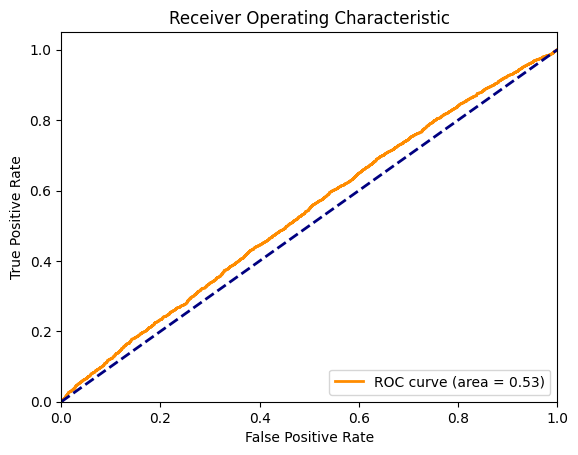

In [ ]:
# Predict probabilities for the test data
y_probs = log_reg.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probs)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

# Plot the ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Accuracy: 0.52
Precision: 0.53
Recall: 0.39
F1-Score: 0.45
ROC-AUC: 0.53

Classification Report:
              precision    recall  f1-score   support

         0.0       0.52      0.65      0.57      4152
         1.0       0.53      0.39      0.45      4165

    accuracy                           0.52      8317
   macro avg       0.52      0.52      0.51      8317
weighted avg       0.52      0.52      0.51      8317



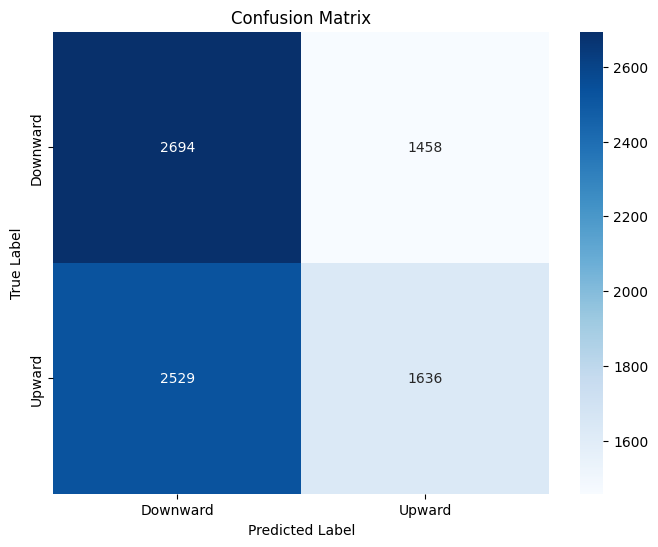

In [ ]:
# Calculate additional metrics
f1 = f1_score(y_test, y_pred)

# Print structured output
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

# Print full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Downward', 'Upward'], yticklabels=['Downward', 'Upward'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#TUNE PARAMETERS

# Define the model
model = LogisticRegression(max_iter=1000)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']  # Only one solver in the grid
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Perform the grid search on scaled data
grid_search.fit(X_train, y_train)

# Best parameters and best score from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Re-train the model with the best parameters on the training data
best_model = LogisticRegression(**best_params, max_iter=1000, tol=0.01)
best_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC-AUC Score:", roc_auc)




Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.5327941837800957
Accuracy: 0.5192978237345196
Precision: 0.5279919544083138
Recall: 0.37815126050420167
ROC-AUC Score: 0.5325361936682187


## Decision Trees Model

Accuracy: 0.51
Precision: 0.51
Recall: 0.50
ROC-AUC: 0.51

Classification Report:
              precision    recall  f1-score   support

         0.0       0.51      0.52      0.52      4152
         1.0       0.51      0.50      0.51      4165

    accuracy                           0.51      8317
   macro avg       0.51      0.51      0.51      8317
weighted avg       0.51      0.51      0.51      8317



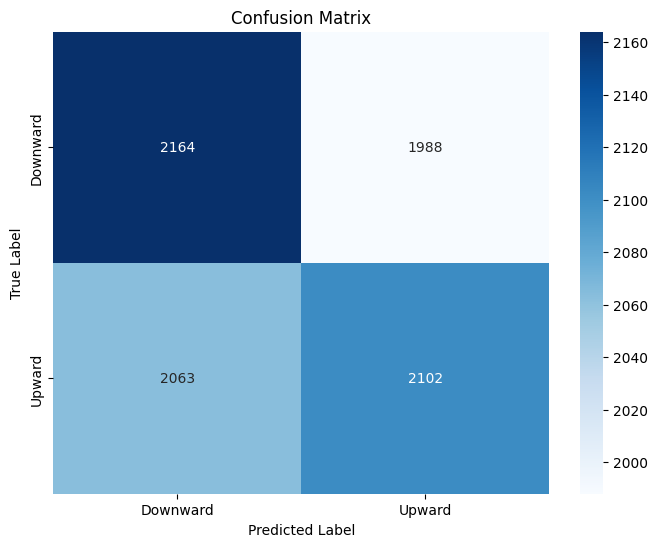

In [ ]:
# Initialize the Decision Tree Classifier
tree_model = DecisionTreeClassifier(random_state=42)

# Train the model on the preprocessed training data
tree_model.fit(X_train, y_train)

# Predict on the preprocessed test data
y_pred = tree_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, tree_model.predict_proba(X_test)[:, 1])

# Print performance metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

# Display the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Downward', 'Upward'], yticklabels=['Downward', 'Upward'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
#FINE TUNE MODEL

# Parameter grid for Decision Tree
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score: {:.2f}".format(grid_search.best_score_))

# Evaluate the best model
best_tree = grid_search.best_estimator_
y_pred_best = best_tree.predict(X_test)
print("Accuracy of the best model: {:.2f}".format(accuracy_score(y_test, y_pred_best)))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}
Best score: 0.52
Accuracy of the best model: 0.53


## Random Forest Model

Random Forest Accuracy: 0.51
Random Forest Precision: 0.52
Random Forest Recall: 0.48
Random Forest ROC-AUC: 0.52

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.51      0.55      0.53      4152
         1.0       0.52      0.48      0.50      4165

    accuracy                           0.51      8317
   macro avg       0.51      0.51      0.51      8317
weighted avg       0.51      0.51      0.51      8317



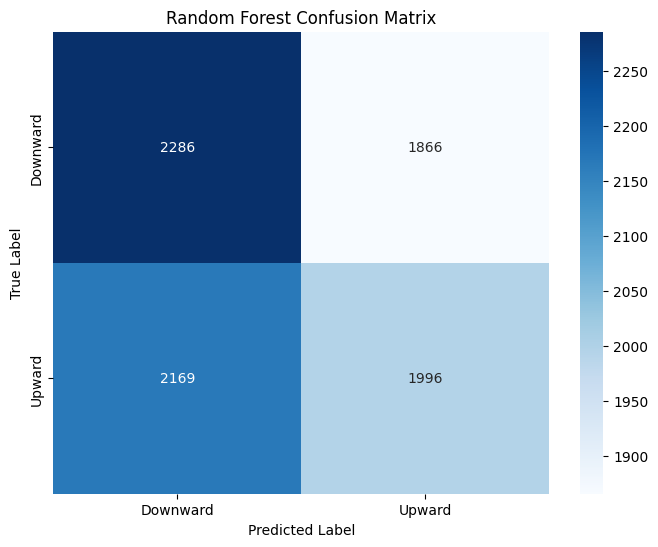

In [ ]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the preprocessed training data
rf_model.fit(X_train, y_train)

# Predict on the preprocessed test data
y_pred_rf = rf_model.predict(X_test)

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

# Print performance metrics
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print(f"Random Forest Precision: {precision_rf:.2f}")
print(f"Random Forest Recall: {recall_rf:.2f}")
print(f"Random Forest ROC-AUC: {roc_auc_rf:.2f}")

# Display the classification report
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix Visualization
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=['Downward', 'Upward'], yticklabels=['Downward', 'Upward'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.show()


In [ ]:
#FINE TUNE MODEL

# Reduced parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
}

# Initialize RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=10,  # Number of parameter settings sampled
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Fit RandomizedSearchCV
random_search_rf.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters for Random Forest:", random_search_rf.best_params_)
print("Best score for Random Forest: {:.2f}".format(random_search_rf.best_score_))

# Evaluate the best Random Forest model
best_rf = random_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print("Accuracy of the best Random Forest model: {:.2f}".format(accuracy_score(y_test, y_pred_best_rf)))



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 10}
Best score for Random Forest: 0.52
Accuracy of the best Random Forest model: 0.53


## Support Vector Machine (SVM) Model

SVM Accuracy: 0.51
SVM Precision: 0.52
SVM Recall: 0.35
SVM ROC-AUC: 0.53

SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.51      0.68      0.58      4152
         1.0       0.52      0.35      0.42      4165

    accuracy                           0.51      8317
   macro avg       0.51      0.51      0.50      8317
weighted avg       0.51      0.51      0.50      8317



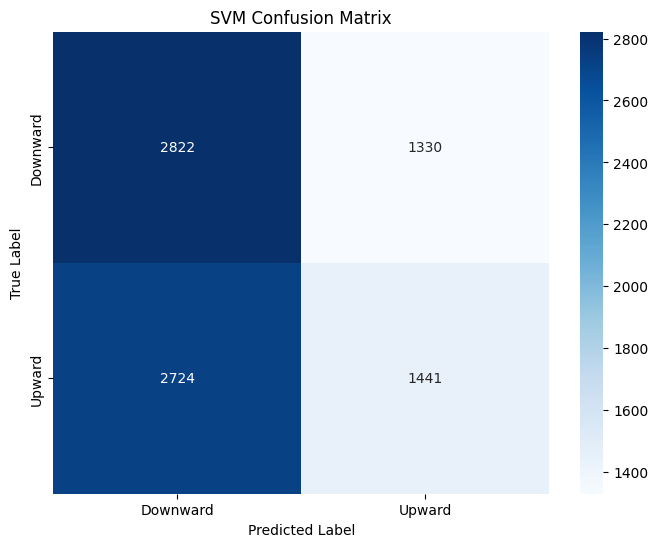

In [ ]:
# Initialize the SVM classifier
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Train the model on the preprocessed training data
svm_model.fit(X_train, y_train)

# Predict on the preprocessed test data
y_pred_svm = svm_model.predict(X_test)

# Calculate metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, svm_model.predict_proba(X_test)[:, 1])

# Print performance metrics
print(f"SVM Accuracy: {accuracy_svm:.2f}")
print(f"SVM Precision: {precision_svm:.2f}")
print(f"SVM Recall: {recall_svm:.2f}")
print(f"SVM ROC-AUC: {roc_auc_svm:.2f}")

# Display the classification report
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix Visualization
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=['Downward', 'Upward'], yticklabels=['Downward', 'Upward'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix')
plt.show()


In [ ]:
#FINE TUNE MODEL

# Reduced parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize HalvingGridSearchCV for SVM
halving_search_svm = HalvingGridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid_svm,
    factor=2,  # Factor by which the number of candidates is reduced at each iteration
    cv=3,  # Reduce number of cross-validation folds
    scoring='accuracy',
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit HalvingGridSearchCV
halving_search_svm.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters for SVM:", halving_search_svm.best_params_)
print("Best score for SVM: {:.2f}".format(halving_search_svm.best_score_))

# Evaluate the best SVM model
best_svm = halving_search_svm.best_estimator_
y_pred_best_svm = best_svm.predict(X_test)
print("Accuracy of the best SVM model: {:.2f}".format(accuracy_score(y_test, y_pred_best_svm)))



n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 4158
max_resources_: 33268
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 12
n_resources: 4158
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 6
n_resources: 8316
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 3
n_resources: 16632
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 33264
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters for SVM: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Best score for SVM: 0.52
Accuracy of the best SVM model: 0.52


## K-Nearest Neighbors (KNN) Model

KNN Accuracy: 0.51
KNN Precision: 0.51
KNN Recall: 0.49
KNN ROC-AUC: 0.51

KNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.51      0.52      0.51      4152
         1.0       0.51      0.49      0.50      4165

    accuracy                           0.51      8317
   macro avg       0.51      0.51      0.51      8317
weighted avg       0.51      0.51      0.51      8317



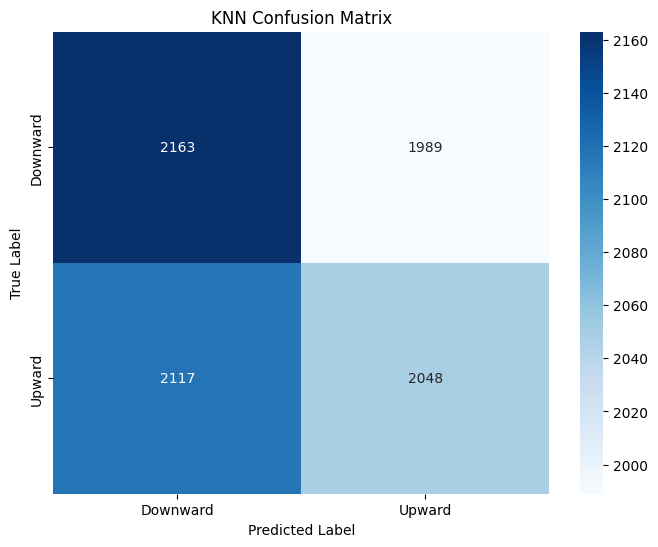

In [ ]:
# Initialize the KNN Classifier
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model on the preprocessed training data
knn_model.fit(X_train, y_train)

# Predict on the preprocessed test data
y_pred_knn = knn_model.predict(X_test)

# Calculate metrics
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, knn_model.predict_proba(X_test)[:, 1])

# Print performance metrics
print(f"KNN Accuracy: {accuracy_knn:.2f}")
print(f"KNN Precision: {precision_knn:.2f}")
print(f"KNN Recall: {recall_knn:.2f}")
print(f"KNN ROC-AUC: {roc_auc_knn:.2f}")

# Display the classification report
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Confusion Matrix Visualization
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=['Downward', 'Upward'], yticklabels=['Downward', 'Upward'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('KNN Confusion Matrix')
plt.show()


In [ ]:
# FINE TUNE MODEL

# Parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan']
}

# Initialize GridSearchCV for KNN
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy', verbose=1)

# Fit GridSearchCV
grid_search_knn.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters for KNN:", grid_search_knn.best_params_)
print("Best score for KNN: {:.2f}".format(grid_search_knn.best_score_))

# Evaluate the best KNN model
best_knn = grid_search_knn.best_estimator_
y_pred_best_knn = best_knn.predict(X_test)
print("Accuracy of the best KNN model: {:.2f}".format(accuracy_score(y_test, y_pred_best_knn)))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 9}
Best score for KNN: 0.51
Accuracy of the best KNN model: 0.51


## Neural Networks Model

In [ ]:
# Initialize the model
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

# Additional hidden layers
model.add(Dense(32, activation='relu'))  # Second hidden layer
model.add(Dropout(0.2))                  # Dropout layer for regularization

# Output layer
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Evaluate the model on test data
results = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}, Precision: {results[2]}, Recall: {results[3]}, AUC: {results[4]}")


Epoch 1/50
832/832 [==============================] - 6s 4ms/step - loss: 0.6959 - accuracy: 0.5144 - precision_2: 0.5076 - recall_2: 0.5043 - auc_2: 0.5246 - val_loss: 0.6912 - val_accuracy: 0.5239 - val_precision_2: 0.5158 - val_recall_2: 0.2978 - val_auc_2: 0.5338
Epoch 2/50
832/832 [==============================] - 2s 2ms/step - loss: 0.6919 - accuracy: 0.5191 - precision_2: 0.5124 - recall_2: 0.5097 - auc_2: 0.5275 - val_loss: 0.6903 - val_accuracy: 0.5216 - val_precision_2: 0.5062 - val_recall_2: 0.5538 - val_auc_2: 0.5351
Epoch 3/50
832/832 [==============================] - 2s 3ms/step - loss: 0.6910 - accuracy: 0.5225 - precision_2: 0.5138 - recall_2: 0.5870 - auc_2: 0.5320 - val_loss: 0.6913 - val_accuracy: 0.5161 - val_precision_2: 0.5010 - val_recall_2: 0.5705 - val_auc_2: 0.5308
Epoch 4/50
832/832 [==============================] - 3s 4ms/step - loss: 0.6908 - accuracy: 0.5233 - precision_2: 0.5140 - recall_2: 0.6078 - auc_2: 0.5334 - val_loss: 0.6910 - val_accuracy: 0.51

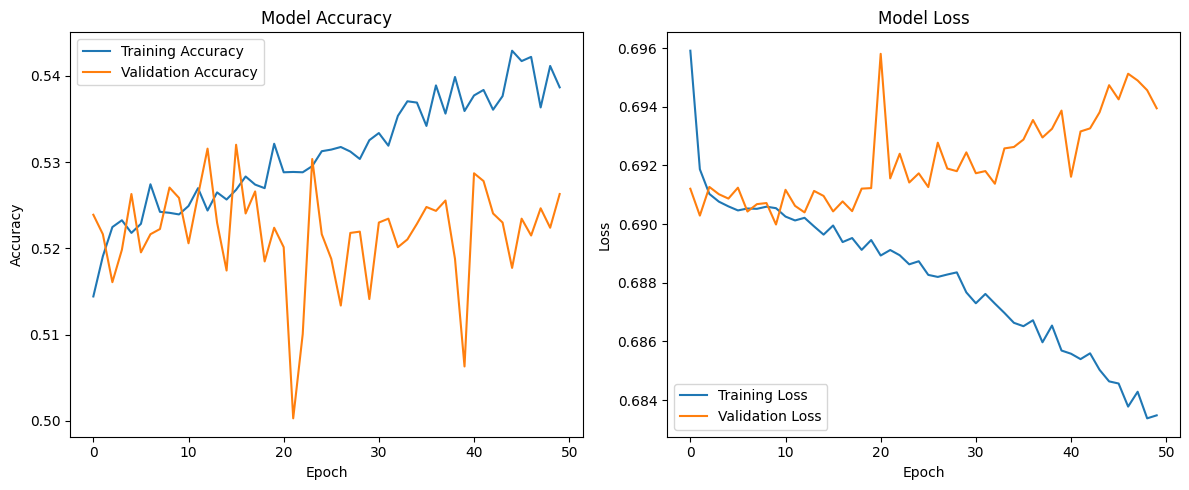

In [ ]:
#PLOT TRAINING HISTORY

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
## REVIEW AND ENHANCE MODEL ARCHITECTURE

model = Sequential()

# Input layer and first hidden layer with increased neurons and batch normalization
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())

# Additional hidden layers with batch normalization and increased complexity
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))  # Adjusted dropout rate

model.add(Dense(32, activation='relu'))  # Added an extra hidden layer
model.add(BatchNormalization())
model.add(Dropout(0.2))  # Adjusted dropout rate

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model with the same optimizer and loss function
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model with callbacks
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test set
evaluation = model.evaluate(X_test, y_test)
print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]:.4f}")
print(f"Test Precision: {evaluation[2]:.4f}")
print(f"Test Recall: {evaluation[3]:.4f}")
print(f"Test AUC: {evaluation[4]:.4f}")



Epoch 1/100
832/832 [==============================] - 6s 4ms/step - loss: 0.7291 - accuracy: 0.5037 - precision_3: 0.4967 - recall_3: 0.4906 - auc_3: 0.5073 - val_loss: 0.6948 - val_accuracy: 0.5113 - val_precision_3: 0.4939 - val_recall_3: 0.3117 - val_auc_3: 0.5201 - lr: 0.0010
Epoch 2/100
832/832 [==============================] - 3s 4ms/step - loss: 0.6979 - accuracy: 0.5113 - precision_3: 0.5045 - recall_3: 0.5034 - auc_3: 0.5186 - val_loss: 0.6910 - val_accuracy: 0.5201 - val_precision_3: 0.5072 - val_recall_3: 0.3706 - val_auc_3: 0.5300 - lr: 0.0010
Epoch 3/100
832/832 [==============================] - 5s 5ms/step - loss: 0.6932 - accuracy: 0.5153 - precision_3: 0.5088 - recall_3: 0.4899 - auc_3: 0.5242 - val_loss: 0.6908 - val_accuracy: 0.5117 - val_precision_3: 0.4972 - val_recall_3: 0.6130 - val_auc_3: 0.5276 - lr: 0.0010
Epoch 4/100
832/832 [==============================] - 3s 4ms/step - loss: 0.6921 - accuracy: 0.5204 - precision_3: 0.5135 - recall_3: 0.5171 - auc_3: 0.5

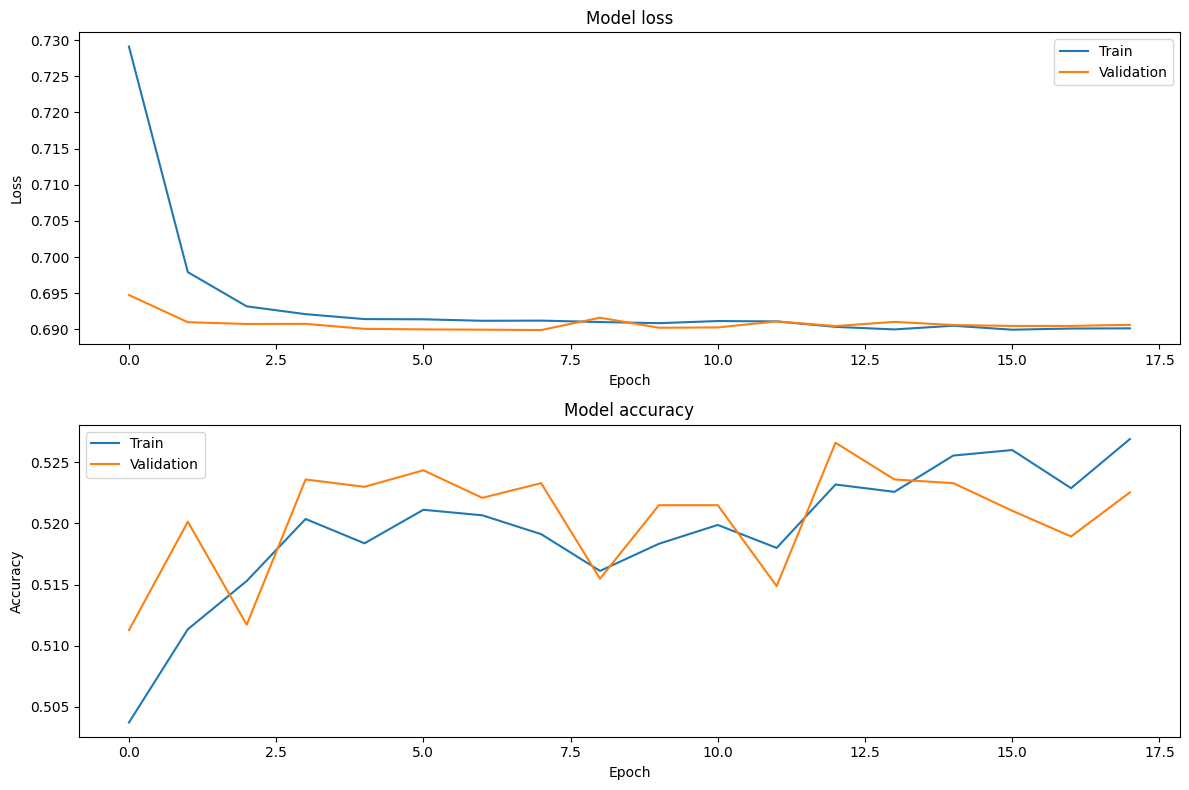

In [ ]:
# Plot training history
plt.figure(figsize=(12, 8))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Training fold 1...
Epoch 1/100
1040/1040 [==============================] - 13s 6ms/step - loss: 0.7301 - accuracy: 0.5058 - precision_4: 0.4991 - recall_4: 0.4865 - auc_4: 0.5098 - val_loss: 0.6948 - val_accuracy: 0.5075 - val_precision_4: 0.5011 - val_recall_4: 0.3829 - val_auc_4: 0.5025 - lr: 0.0010
Epoch 2/100
1040/1040 [==============================] - 4s 4ms/step - loss: 0.7003 - accuracy: 0.5088 - precision_4: 0.5022 - recall_4: 0.4842 - auc_4: 0.5112 - val_loss: 0.7022 - val_accuracy: 0.4764 - val_precision_4: 0.4467 - val_recall_4: 0.2576 - val_auc_4: 0.4273 - lr: 0.0010
Epoch 3/100
1040/1040 [==============================] - 5s 5ms/step - loss: 0.6934 - accuracy: 0.5155 - precision_4: 0.5091 - recall_4: 0.4975 - auc_4: 0.5222 - val_loss: 0.6966 - val_accuracy: 0.4951 - val_precision_4: 0.4704 - val_recall_4: 0.1860 - val_auc_4: 0.4936 - lr: 0.0010
Epoch 4/100
1040/1040 [==============================] - 4s 4ms/step - loss: 0.6928 - accuracy: 0.5142 - precision_4: 0.5084 - r

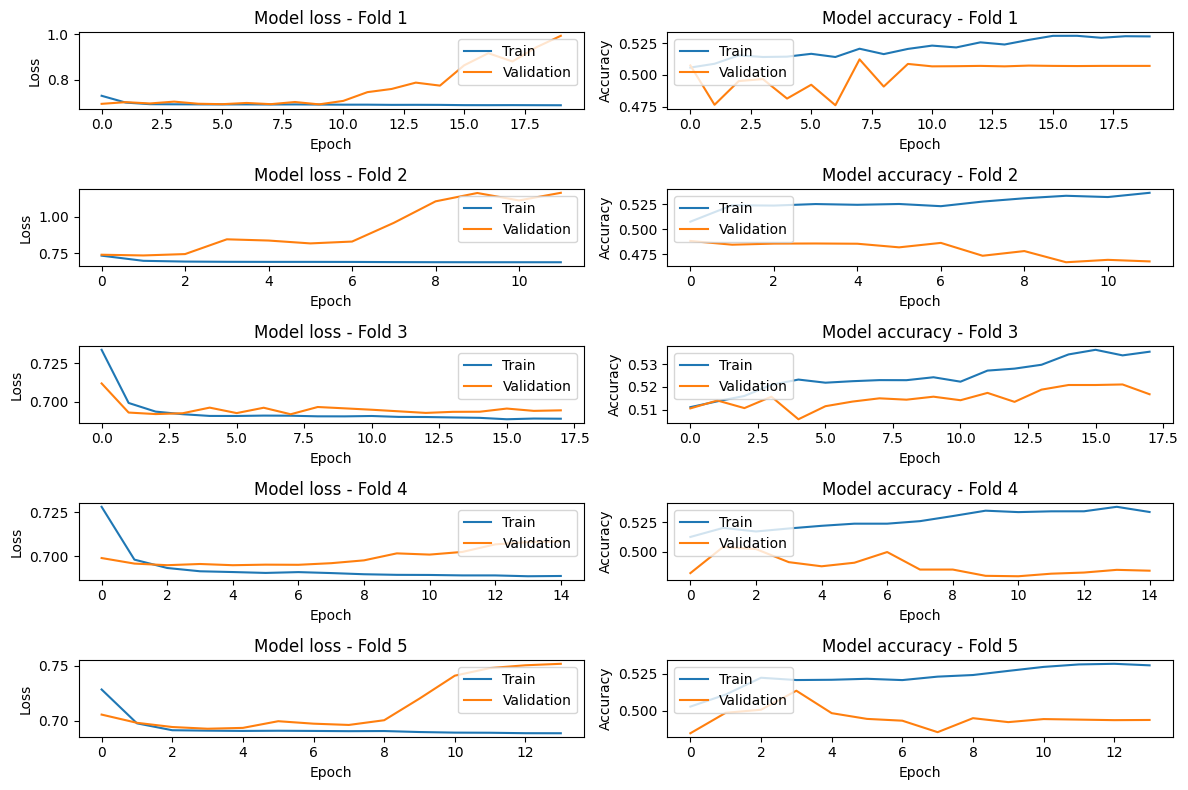

In [ ]:
## CROSS-VALIDATION WITH KFOLD

# Convert X and y to numpy arrays if they are pandas DataFrames/Series
X = X.values if hasattr(X, 'values') else X
y = y.values if hasattr(y, 'values') else y

# Define the model architecture
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
    return model

# Cross-validation setup
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

# Collect results
fold_no = 1
histories = []

for train_index, val_index in skf.split(X, y):
    print(f'Training fold {fold_no}...')

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_model(input_dim=X_train.shape[1])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

    history = model.fit(X_train, y_train,
                        epochs=100,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, reduce_lr],
                        verbose=1)

    histories.append(history)
    fold_no += 1

# Plot training history for each fold
plt.figure(figsize=(12, 8))

for i, history in enumerate(histories):
    plt.subplot(n_splits, 2, 2*i+1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - Fold {i+1}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(n_splits, 2, 2*i+2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - Fold {i+1}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()




Training fold 1...
Epoch 1/100
1040/1040 [==============================] - 12s 8ms/step - loss: 1.5780 - accuracy: 0.5004 - precision_14: 0.4935 - recall_14: 0.4807 - auc_14: 0.5002 - val_loss: 0.9030 - val_accuracy: 0.4901 - val_precision_14: 0.4855 - val_recall_14: 0.5647 - val_auc_14: 0.4802 - lr: 0.0010
Epoch 2/100
1040/1040 [==============================] - 3s 3ms/step - loss: 0.7623 - accuracy: 0.5039 - precision_14: 0.4971 - recall_14: 0.4908 - auc_14: 0.5090 - val_loss: 0.7161 - val_accuracy: 0.4815 - val_precision_14: 0.4794 - val_recall_14: 0.5932 - val_auc_14: 0.4718 - lr: 0.0010
Epoch 3/100
1040/1040 [==============================] - 3s 3ms/step - loss: 0.6996 - accuracy: 0.5076 - precision_14: 0.5009 - recall_14: 0.4966 - auc_14: 0.5120 - val_loss: 0.6959 - val_accuracy: 0.5139 - val_precision_14: 0.5270 - val_recall_14: 0.1426 - val_auc_14: 0.5475 - lr: 0.0010
Epoch 4/100
1040/1040 [==============================] - 4s 4ms/step - loss: 0.6966 - accuracy: 0.5085 - preci

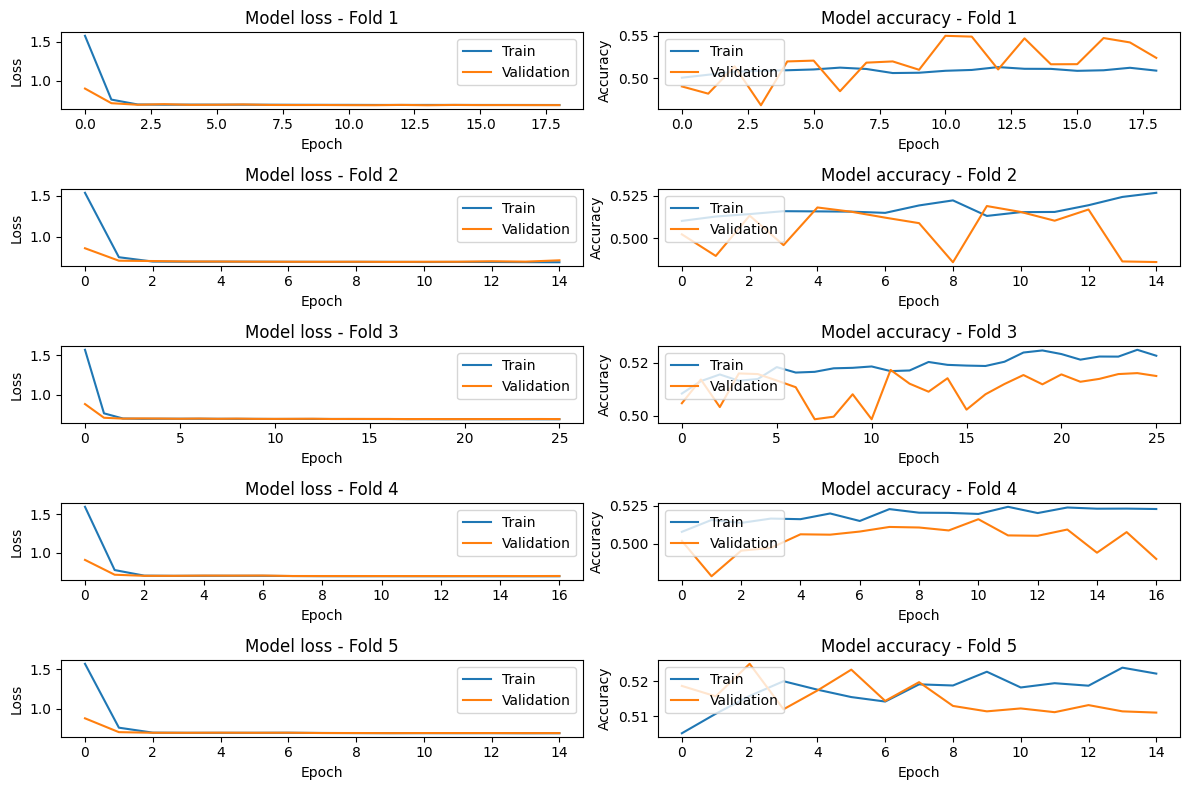

In [ ]:
## ENHANCED CROSS-VALIDATION WITH KFOLD

# Convert X and y to numpy arrays if they are pandas DataFrames/Series
X = X.values if hasattr(X, 'values') else X
y = y.values if hasattr(y, 'values') else y

# Define the model architecture
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)))  # Increased L2 regularization
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))  # Increased dropout rate
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))  # Increased dropout rate
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
    return model

# Cross-validation setup
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

# Collect results
fold_no = 1
histories = []

for train_index, val_index in skf.split(X, y):
    print(f'Training fold {fold_no}...')

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_model(input_dim=X_train.shape[1])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

    history = model.fit(X_train, y_train,
                        epochs=100,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, reduce_lr],
                        verbose=1)

    histories.append(history)
    fold_no += 1

# Plot training history for each fold
plt.figure(figsize=(12, 8))

for i, history in enumerate(histories):
    plt.subplot(n_splits, 2, 2*i+1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - Fold {i+1}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(n_splits, 2, 2*i+2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - Fold {i+1}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()



## ANALYSIS

**Loss Analysis:**
Rapid decrease in training and validation loss within the first few epochs in all folds indicates that the model quickly learns some basic patterns in the data. After the initial decrease, the training loss stabilizes, but the validation loss fluctuates significantly across epochs. The validation loss in some folds starts to diverge from the training loss, which is a sign of overfitting. These patterns suggest that the model is learning specific patterns from the training data that do not generalize well to the validation data.<br>

**Accuracy Analysis:**
The training accuracy tends to stabilize around 0.52 to 0.55 across different folds, indicating a consistent performance on the training data.  The validation accuracy fluctuates more compared to the training accuracy. This variability suggests that the model's performance on unseen data is not stable and might be sensitive to the specific split of the data. With accuracy values around 0.50, the model's performance is only marginally better than random guessing for a binary classification task.<br>

**Recommendations for Improvement:** <br>
**Increase Data Volume:** More training data might help the model to generalize better and reduce overfitting. <br>
**Increased Feature Engineering:** Add more informative features or using advanced feature engineering techniques might help in improving model performance. <br>
**Regularization Techniques:** Increase dropout rates to prevent the model from overfitting or applying L2 regularization to penalize large weights and encourage the model to find simpler patterns. <br>
**Model Architecture:** Experiment with different architectures (e.g., more layers, different activation functions) might improve performance.<br>
**Data Augmentation:** For time-series data, techniques such as jittering, scaling, and window slicing can be used to artificially increase the size of the dataset.<br>